In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import matplotlib.dates as mdates
from datetime import datetime, timedelta
pd.set_option('display.max_rows', 500)

In [2]:
confirmed_df = pd.read_csv(r'../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
confirmed_df.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region'}, inplace=True)
confirmed_df.head()

,Province_State,Country_Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,639,701,773,839,825,878,889,924,963
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,178,200,212,226,243,266,313,345,385
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,149,197,238,428,566,673,790,900,1030


In [3]:
def create_df(a_series):
    dates = a_series.index[4:].values
    counts = a_series.values[4:]
    df = pd.DataFrame({'date': dates, 'count': counts})
    df['Province_State'] = a_series['Province_State'] 
    df['Country_Region'] = a_series['Country_Region'] 
    df['Lat'] = a_series['Lat'] 
    df['Long'] = a_series['Long'] 
    return df

In [4]:
confirmed_df_2 = pd.concat(confirmed_df.apply(create_df, axis=1).values).set_index(['Country_Region', 'Province_State', 'Lat', 'Long'])
confirmed_df_2['date'] = pd.to_datetime(confirmed_df_2['date'])
confirmed_df_2.head()

date count
Country_Region Province_State Lat  Long                  
Thailand       NaN            15.0 101.0 2020-01-22     2
                                   101.0 2020-01-23     3
                                   101.0 2020-01-24     5
                                   101.0 2020-01-25     7
                                   101.0 2020-01-26     8

In [5]:
country_df = confirmed_df_2.query('Country_Region == "Israel"')
country_df.tail()

date count
Country_Region Province_State Lat  Long                 
Israel         NaN            31.0 35.0 2020-03-16   255
                                   35.0 2020-03-17   337
                                   35.0 2020-03-18   433
                                   35.0 2020-03-19   677
                                   35.0 2020-03-20   705

In [24]:
values = list(country_df.index[0]) + [last_date + timedelta(days=1), 887]
values

['Israel', nan, 31.0, 35.0, Timestamp('2020-03-21 00:00:00'), 887]

In [21]:
columns = list(country_df.index.names) + country_df.columns.tolist()
columns

['Country_Region', 'Province_State', 'Lat', 'Long', 'date', 'count']

In [6]:
last_date = country_df['date'].iloc[-1]
last_date

Timestamp('2020-03-20 00:00:00')

In [30]:
values = list(country_df.index[0]) + [last_date + timedelta(days=1), 887]
columns = list(country_df.index.names) + country_df.columns.tolist()
values, columns
row_df = pd.DataFrame([values], columns=columns).set_index(country_df.index.names)
row_df

,,,,date,count
Country_Region,Province_State,Lat,Long,,
Israel,NaN,31.0,35.0,2020-03-21,887


In [35]:
country_updated_df = country_df.append(row_df)
country_updated_df.tail()

date count
Country_Region Province_State Lat  Long                 
Israel         NaN            31.0 35.0 2020-03-17   337
                                   35.0 2020-03-18   433
                                   35.0 2020-03-19   677
                                   35.0 2020-03-20   705
                                   35.0 2020-03-21   887

<IPython.core.display.Javascript object>


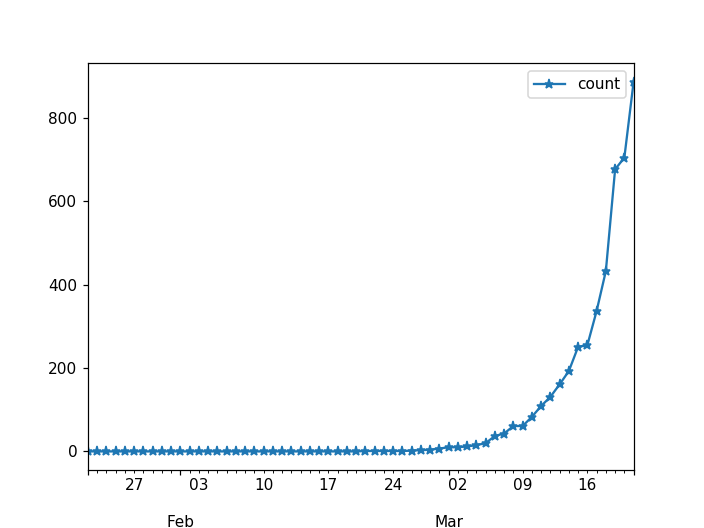

In [36]:
%matplotlib notebook
country_updated_df.plot(x='date', y='count', marker='*')

In [37]:
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b

In [38]:
non_zero_country_df = country_updated_df[country_updated_df['count'] > 0]
y_array_exp = non_zero_country_df['count'].values
ref_date = datetime(2020, 1, 1)
x_array = (non_zero_country_df['date'] - ref_date).dt.days.values.astype(float)

In [39]:
last_model_date = country_updated_df['date'].iloc[-1]
# last_model_date = datetime(2020, 3, 18)
last_model_index = np.argmin((non_zero_country_df['date'] - last_model_date).abs().values)
last_model_index

29

In [40]:
popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, x_array[:last_model_index], y_array_exp[:last_model_index], p0=
(0.0021819439144763727, 0.2196989290489097, -0.8576298838011189))
a, k, b = popt_exponential
a, k, b, np.exp(k), np.exp(k*7)

(1.1695955156670942e-05,
 0.22728241090630052,
 0.6095407427362807,
 1.2551842956253034,
 4.908541625207097)

In [41]:
estimated = exponential(x_array, a, k, b)
non_zero_country_df['estimated'] = estimated
estimated

/home/erez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([  1.87462088,   2.19744946,   2.60265883,   3.11127126,
         3.7496736 ,   4.55098619,   5.55678117,   6.81923924,
         8.40385678,  10.39284382,  12.88938913,  16.02301359,
        19.9562898 ,  24.89327633,  31.09010429,  38.86826543,
        48.63129115,  60.8856877 ,  76.2672138 ,  95.57386381,
       119.8072677 , 150.2246557 , 188.40408342, 236.32630151,
       296.47751708, 371.97837822, 466.74587343, 585.69654515,
       735.00156025, 922.40687046])

<IPython.core.display.Javascript object>


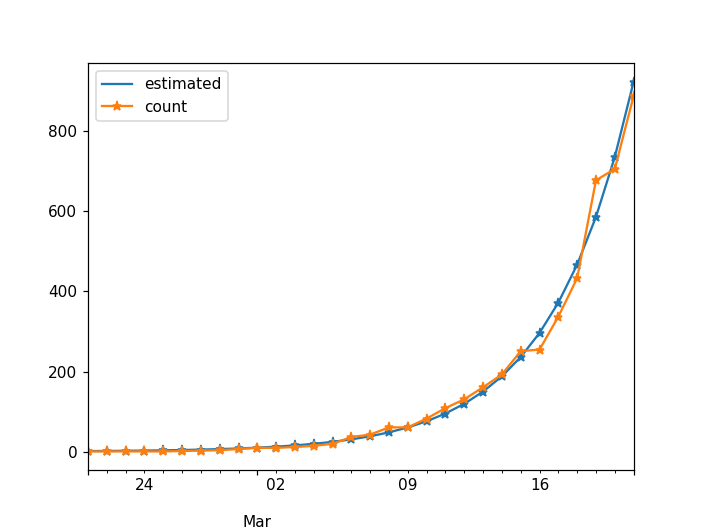

In [42]:
plt.figure()
ax = plt.gca()
non_zero_country_df.plot(ax=ax, x='date', y='estimated' ,marker='*')
non_zero_country_df.plot(ax=ax, x='date', y='count' ,marker='*')
plt.show()

In [43]:
non_zero_country_df

date count   estimated
Country_Region Province_State Lat  Long                             
Israel         NaN            31.0 35.0 2020-02-21     1    1.874621
                                   35.0 2020-02-22     1    2.197449
                                   35.0 2020-02-23     1    2.602659
                                   35.0 2020-02-24     1    3.111271
                                   35.0 2020-02-25     1    3.749674
                                   35.0 2020-02-26     2    4.550986
                                   35.0 2020-02-27     3    5.556781
                                   35.0 2020-02-28     4    6.819239
                                   35.0 2020-02-29     7    8.403857
                                   35.0 2020-03-01    10   10.392844
                                   35.0 2020-03-02    10   12.889389
                                   35.0 2020-03-03    12   16.023014
                                   35.0 2020-03-04    15   19.956290
                                   35.0 2020-03-05    20   24.893276
                                   35.0 2020-03-06    37   31.090104
                                   35.0 2020-03-07    43   38.868265
                                   35.0 2020-03-08    61   48.631291
                                   35.0 2020-03-09    61   60.885688
                                   35.0 2020-03-10    83   76.267214
                                   35.0 2020-03-11   109   95.573864
                                   35.0 2020-03-12   131  119.807268
                                   35.0 2020-03-13   161  150.224656
                                   35.0 2020-03-14   193  188.404083
                                   35.0 2020-03-15   251  236.326302
                                   35.0 2020-03-16   255  296.477517
                                   35.0 2020-03-17   337  371.978378
                                   35.0 2020-03-18   433  466.745873
                                   35.0 2020-03-19   677  585.696545
                                   35.0 2020-03-20   705  735.001560
                                   35.0 2020-03-21   887  922.406870

In [44]:
extrapolation_dates_series = pd.Series([last_model_date + timedelta(days=k) for k in range(1, 14)])
extrapolation_x_array = (extrapolation_dates_series - ref_date).dt.days.values.astype(float)
extrapolation_estimated = exponential(extrapolation_x_array, a, k, b)
extrapolation_df = pd.DataFrame({'date': extrapolation_dates_series, 'estimated': extrapolation_estimated})
extrapolation_df

,date,estimated
0,2020-03-22,1157.635073
1,2020-03-23,1452.889818
2,2020-03-24,1823.488938
3,2020-03-25,2288.659133
4,2020-03-26,2872.533456
5,2020-03-27,3605.403338
6,2020-03-28,4525.290104
7,2020-03-29,5679.917526
8,2020-03-30,7129.187734
9,2020-03-31,8948.288939


<IPython.core.display.Javascript object>


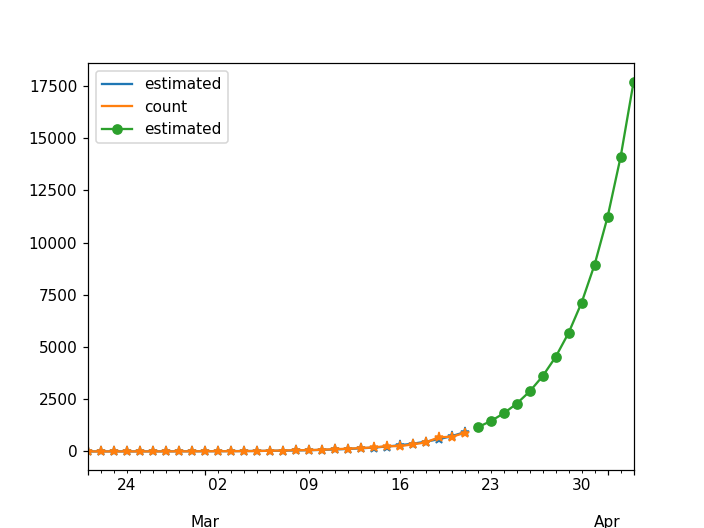

In [45]:
plt.figure()
ax = plt.gca()
non_zero_country_df.plot(ax=ax, x='date', y='estimated' ,marker='*')
non_zero_country_df.plot(ax=ax, x='date', y='count' ,marker='*')
extrapolation_df.plot(ax=ax, x='date', y='estimated' ,marker='o')
plt.show()

In [46]:
# %matplotlib notebook
# plt.figure(figsize=(9, 8))
# for iteration in range(0, 8):
#     plt.subplot(331 + iteration)
#     n_days = int(iteration * 7)
#     x_long_term = range(len(y_array_exp) + n_days)
#     y_forecast = exponential(x_long_term, a, k, b)
#     max_val = y_forecast.max() 
#     plt.plot(estimated)
#     plt.plot(y_array_exp, '--*')
#     plt.plot(y_forecast, '--b')
#     plt.title(f'weeks from now: {iteration}\ncases:{int(max_val):,}', y=.5)